Author:      Abhijeet Singh

Copyright:   Copyright (©) 2018 EPFL (Ecole Polytechnique Fédérale de Lausanne)
             Geo-Energy lab

# Mesh convergence study for circular hole in an infinite medium subjected to internal pressure

Combined problem of a circular hole of radius r in an infinite medium subjected to internal pressure p, and a circular plate of radius r subjected to external pressure p to get a displacement discontinuity problem

Set the Bigwham directory (check on yours)

In [1]:
import os, sys
home = os.environ["HOME"]
sys.path.append(home + "/BigWham/build/interfaces/python")

Import necessary libraries

In [2]:
import numpy as np
from hmatrix_rectangular import HmatrixRectangular
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, LinearOperator
from scipy.sparse import csr_matrix
from py_bigwham import Mesh

Set fontname of matplotlib

In [3]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# User Inputs

In [4]:
# Specify material elastic properties
# Young's modulus (in MPa)
E         = 2.e5
# Poisson's ratio
nu        = 0.3
# Shear Modulus
G = E/(2*(1+nu))

# Specify pressure (in MPa)
p  = 1.e2
# Specify hole radius (in mm)
r  = 1.0

# How fine mesh sizes are in comparison to the next largest one
mesh_factor = 2
# Specify desired mesh size(s)
n_elmts = 20 * mesh_factor**np.linspace(0, 8, 9, dtype = np.int_)

# Vector to store radial displacement values for different mesh sizes
u_r_vals = np.zeros(n_elmts.shape[0])


H-matrix parameters

In [5]:
# H-matrix parameter

max_leaf_size = 16
eta           = 3.0
eps_aca       = 1.e-4

# Solve the problem for various mesh sizes

In [6]:
# Solve the problem to get displacements for each mesh size
for i in range(n_elmts.shape[0]):

    # Get coordinates and connectivity matrix

    # Angle spanned by each element
    theta = 2*np.pi/n_elmts[i]
    # Create the mesh of circle
    coord = np.zeros([n_elmts[i],2])
    for j in range(n_elmts[i]):
        # Assign x-coordinates (intentionally shifting by theta/2, which makes easy to put BCs on colocation points)
        coord[j,0] = r*np.cos(theta*j - theta/2)
        # Assign y-coordinates (intentionally shifting by theta/2, which makes easy to put BCs on colocation points)
        coord[j,1] = r*np.sin(theta*j - theta/2)

    # Make the connectivity matrix
    conn = np.fromfunction(lambda x, y: x + y, (n_elmts[i], 2), dtype=np.int_)
    # Put the last element with 0th node as the end node because it's a circle
    conn[-1,1] = conn[0,0]

    # Compute H matrix 
    H = HmatrixRectangular(
        "2DS0-2DS0-H",
        coord.flatten(),
        conn.flatten(),
        coord.flatten(),
        conn.flatten(),
        np.array([E, nu]),
        max_leaf_size,
        eta,
        eps_aca,
    )

    # Get the collocation points
    col_pts = H.getMeshCollocationPoints()

    # Implement traction on local coordinates using pressure
    t_local      = np.zeros([n_elmts[i], 2])
    t_local[:,1] = -p

    # Get displacements using traction vector
    u, info = gmres(H, t_local.flatten())
    # Obtain displacements by converting to global co-ordinates
    disp    = (H.convert_to_global(u)).reshape(-1,2)

    # Get mean radial displacement value for every mesh size
    u_r_vals[i] = np.mean(u[1::2])
    

# Theoretical radial displacement of hollow circle subjected to internal pressure
u_r_1 = p*r/(2*G)
# Theoretical radial displacement of solid circle subjected to external pressure
u_r_2 = -(1-2*nu)*p*r/(2*G)
# Total displacement discontinuity
u_r_th = u_r_1 - u_r_2    

# Obtain the relative error in mean displacement value for each mesh size
rel_err = np.abs(-u_r_vals - u_r_th)/u_r_th
    

 Now setting things for kernel ... 2DS0-2DS0-H with properties size 2
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  6.875e-06
 binary cluster tree depth =1
 Number of blocks =4
 Number of full blocks =4
 Number of low rank blocks =0
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00147321
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
 Now setting things for kernel ... 2DS0-2DS0-H with properties size 2
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  2.0105e-05
 binary cluster tree depth =2
 Number of blocks =16
 Number of full blocks =16
 Number of low rank blocks =0
 Loop on full blocks construction  
 N full bl

# Print theoretical and numerical values to cross-check

In [7]:
print(f"Theoretical radial displacement discontinuity is: {u_r_th:.4e}")
for k in range(n_elmts.shape[0]):
    print(f"Radial displacement discontinuity for {n_elmts[k]} mesh elements is: {-u_r_vals[k]:.4e}")

Theoretical radial displacement discontinuity is: 9.1000e-04
Radial displacement discontinuity for 20 mesh elements is: 9.6262e-04
Radial displacement discontinuity for 40 mesh elements is: 9.3713e-04
Radial displacement discontinuity for 80 mesh elements is: 9.2379e-04
Radial displacement discontinuity for 160 mesh elements is: 9.1695e-04
Radial displacement discontinuity for 320 mesh elements is: 9.1349e-04
Radial displacement discontinuity for 640 mesh elements is: 9.1175e-04
Radial displacement discontinuity for 1280 mesh elements is: 9.1088e-04
Radial displacement discontinuity for 2560 mesh elements is: 9.1044e-04
Radial displacement discontinuity for 5120 mesh elements is: 9.1022e-04


# Plot of relative error of radial displacement discontinuity v/s mesh size

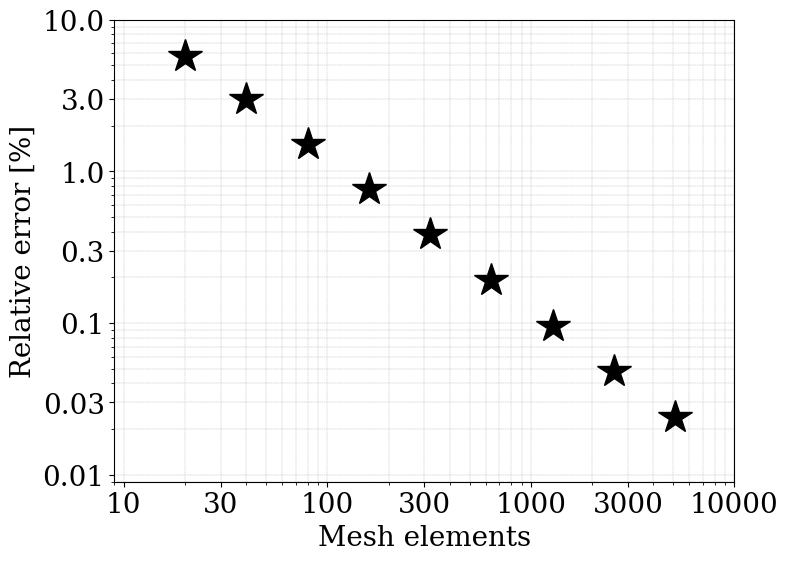

In [8]:
plt.figure(figsize=(8, 6))
# Create the plot
plt.loglog(n_elmts, rel_err*1e2, color = 'black', marker='*', linestyle='None', markersize=25)
# Add grid
plt.grid(True)
# Add labels with LaTeX formatting
plt.xlabel(r'Mesh elements', fontsize=20)
plt.ylabel(r'Relative error [%]', fontsize=20)
# plt.title(r'Error in calculating Stress Intensity Factor for various mesh sizes', loc='center', fontsize=15)
# Increase the size of x and y labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Specify x and y limits with a specified number of ticks
plt.xlim(9e0, 1e4)  # x limits
plt.ylim(9e-3, 1e1)       # y limits
# plt.xticks(np.linspace(1.5, 4.0, 6))  # 5 ticks on x-axis
# plt.yticks(np.linspace(-3.5, -1.0, 6))      # 5 ticks on y-axis

# Specify x-ticks and y-ticks
x_ticks = [10, 30, 100, 300, 1000, 3000, 10000]
y_ticks = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

# Set x-ticks and y-ticks
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/combined_problem_rel_error_mesh_size.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/combined_problem_rel_error_mesh_size.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/combined_problem_rel_error_mesh_size.eps', format='eps', dpi=300, bbox_inches='tight')